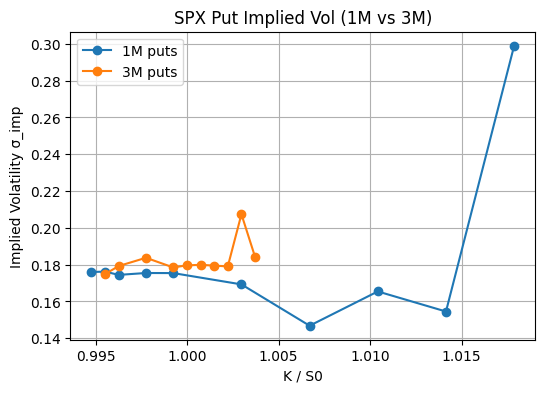

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import log, sqrt, exp
from scipy import stats
def bsm_call_value(S0, K, T, r, sigma):
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    Nd1 = stats.norm.cdf(d1, 0.0, 1.0)
    Nd2 = stats.norm.cdf(d2, 0.0, 1.0)
    value = S0 * Nd1 - K * exp(-r * T) * Nd2
    return value
def bsm_vega(S0, K, T, r, sigma): 
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    pdf_d1 = stats.norm.pdf(d1, 0.0, 1.0)  
    vega = S0 * pdf_d1 * sqrt(T)
    return vega

def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est=0.2, it=100):
    sigma = sigma_est
    for i in range(it):
        price = bsm_call_value(S0, K, T, r, sigma)
        vega = bsm_vega(S0, K, T, r, sigma)
        diff = price - C0
        sigma -= diff / vega
    return sigma
obs_date = "2025-11-24"
S0 = 6705.12
r = 0.05
def compute_iv_puts_bsm(file_name, expiry):
    T = (pd.to_datetime(expiry) - pd.to_datetime(obs_date)).days / 365.0
    df = pd.read_csv(file_name)
    df["K"] = df["Strike"]
    df["P_mkt"] = df["Last Price"]
    df["K_over_S0"] = df["K"] / S0
    discount = np.exp(-r * T)
    df["C_equiv"] = df["P_mkt"] + S0 - df["K"] * discount
    df["sigma_imp"] = df.apply(
        lambda row: bsm_call_imp_vol(
            S0=S0,
            K=row["K"],
            T=T,
            r=r,
            C0=row["C_equiv"],
            sigma_est=0.2
        ),
        axis=1
    )
    return df
exp_1M = "2025-12-24"
exp_3M = "2026-02-27"
file_put_1M = "put one month.csv"    
file_put_3M = "put three month.csv"
df_put_1M = compute_iv_puts_bsm(file_put_1M, exp_1M)
df_put_3M = compute_iv_puts_bsm(file_put_3M, exp_3M)
plt.figure(figsize=(6, 4))
plt.plot(df_put_1M["K_over_S0"], df_put_1M["sigma_imp"], marker="o", label="1M puts")
plt.plot(df_put_3M["K_over_S0"], df_put_3M["sigma_imp"], marker="o", label="3M puts")
plt.xlabel("K / S0")
plt.ylabel("Implied Volatility σ_imp")
plt.title("SPX Put Implied Vol (1M vs 3M)")
plt.grid(True)
plt.legend()
plt.show()
